### 코스피 대형주 33개로 포트폴리오 최적화를 연습한다.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os.path
import scipy.optimize as optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 그래프에서 한글 사용 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True

In [3]:
stockList = pd.read_csv('./stockData/siga.csv') #시가 총액 큰 순
stockList[:10]

,code,name,amount
0,a005930,삼성전자,5969783
1,a000660,SK하이닉스,728002
2,a005380,현대차,213668
3,a068270,셀트리온,128329
4,a051910,LG화학,70592
5,a012330,현대모비스,95307
6,a005490,POSCO,87187
7,a055550,신한지주,474200
8,a207940,삼성바이오로직스,66165
9,a017670,SK텔레콤,80746


#### 저장된 주가 데이터를 읽어와서 종목 별로 연평균 수익률, 변동성 Sharp ratio를 계산한다

In [7]:
def makeRtnVol(): # 으로 정렬한다
            s = s.dropna()
    rtnVol = pd.DataFrame(columns=['name', 'rtn', 'vol', 'sr'])
    rawRtn = pd.DataFrame()
    n = 0
    for row in stockList.itertuples(): # 한 줄씩내려
        # 저장된 주가 데이터를 읽어온다
        stockCode = row.code[1:] #code 앞 a 빼고 숫자부터
        stockName = row.name
        
        file = './stockData/' +  stockCode + '.csv'
        if os.path.isfile(file):  #그런 파일이 있으면 불러 없으번 말고 다음 것 내려와라

            s = pd.read_csv(file, index_col=0, parse_dates=True)
            s = s.sort_index() # 날짜 순
        else:
            continue

        # 일일 수익률을 계산한다.
        s[stockName] = np.log(s.close) - np.log(s.close.shift(1))
        s = s.dropna()
        
        # 종목별 수익률로 한 데이터프레임에 모은다
        # 이 결과는 Covariance matrix 계산에 사용된다
        if n == 0: #맨위 삼성전자부터 수익률만 쪼로롤록 나열될거야
            rawRtn = pd.DataFrame(s[stockName])
        else:
            rawRtn = pd.concat([rawRtn, s[stockName]], axis = 1) #그 다음 것은 가로 축으로 해서 나올거다 concatenate : 이어 붙이다
            
        # '일일 수익률'로 연평균 수익률, 연간 변동성, Sharp ratio를 계산한다.
        yRtn = np.mean(s[stockName]) * 252
        yVol = np.std(s[stockName]) * np.sqrt(252)
        sr = yRtn / yVol
        
        # 계산 결과를 data frame에 저장한다
        rtnVol.loc[n] = [stockName, yRtn, yVol, sr] #n이 증가할 때 마다 밑으로 내려가며 위에서 뽑은 삼성 결과 가로축으로 얘네 이름에 맞게 아래로 내려가며 저장해
        n += 1
    
    rawRtn = rawRtn.dropna()
    return rtnVol, rawRtn.cov()  #통째로 리턴, cob: covariance = 공분산 행렬

#### 위험-수익률 공간에 각 종목을 배치한다.

In [8]:
def plotPortfolio(p):  #위에 종목으로 공간상에 배치해보기
    fig, ax = plt.subplots(figsize=(24, 14))
    for row in p.itertuples():
        # sr이 음수이면 0.001로 설정한다
        if row.sr < 0:
            sr = 0.001
        else:
            sr = row.sr
            
        # 해당 종목을 배치한다. 원의 크기는 Sharp ratio로 한다.
        ax.scatter(row.vol, row.rtn, marker='o', alpha=0.5, s=sr * 5000)
        ax.annotate(row.name, (row.vol, row.rtn))

    ax.set_xlabel('변동성 (위험)')
    ax.set_ylabel('수익률')

#### 포트폴리오 최적화를 위한 목표함수. Sharp Ratio를 최대화한다.

In [9]:
def targetFunc(w, *args):  #w 나중에 외부에서 받을것익 args도 마찬가지.
    rtn = args[0]
    cm = args[1] #convariance matrix
    reg = args[2] # = 0

    portRtn = np.dot(w, rtn) #연간==(분자)
    portVol = np.sqrt(np.dot(w, np.dot(cm, w.T))) * np.sqrt(252) # 연간==(분모)
    sr = portRtn / portVol - reg * np.sum(w ** 2)
    #portVol = np.sqrt(np.dot(w, np.dot(cm, w.T))) * np.sqrt(252) + reg * np.sum(w ** 2)
    return (-1) * sr

#### 제한 조건. Weight의 총합 = 1.0

In [10]:
def constraint1(w):
    return np.sum(w) - 1.0

#### 포트폴리오를 최적화한다.
reg : Regularization constant

In [11]:
def optPortfolio(rv, C, reg=100, opt=True):
    # Weight 행렬을 균등하게 설정한다.
    W = np.ones(len(rv)) * 1/len(rv) #이왕이면 1/n로 해서 그근처의 최소점을 찾는 것이 비교적 좋다.
    R = rv.rtn.values
        
    if opt:
        # 최적 포트폴리오의 비율 (W)을 계산한다
        bnds = ((0.0, 1.0),) * len(W) #W 갯수만큼 bound n리스트
        cons = {'type' : 'eq', 'fun' : constraint1}
        p = optimize.minimize(fun=targetFunc, x0=W, args=(R, C, reg), method='SLSQP', bounds=bnds, constraints=cons)
        #print(p)                 #얘를 초깃값으로 시작ㅡ    공분산 행렬
        
        # 포트폴리오 최적 비율
        W = p.x#해답=------종목갯수만큼 나올것이다.

    portRtn = np.dot(W, R)
    portVol = np.sqrt(np.dot(W, np.dot(C, W.T))) * np.sqrt(252) #투자 성과
    rv['weight'] = W
    
    # weight의 Bar plot을 그린다 , 막대그래프
    plt.figure(figsize=(12, 6))
    x = range(1, len(W) + 1)
    ax = rv['weight'].plot(kind='bar', width=0.8, alpha=0.5)
    ax.set_title("Portfolio Weights")
    ax.set_xlabel("종목")
    ax.set_ylabel("Wehghts")
    ax.set_xticklabels(x)
    
    labels = rv['name']
    for p, i in zip(ax.patches, x):
        ax.annotate(labels[i-1], (p.get_x() * 1.005, p.get_height() * 1.005))
    
    # 최적 포트폴리오 성과를 기록해 둔다
    ret = rv.copy()
    ret.loc[len(rv)] = ('maxSR', portRtn, portVol, portRtn / portVol, 0)
    
    # 최적 포트폴리오 성과를 출력한다.
    print()
    print("* 포트폴리오 수익률 = %.2f (%s)" % (portRtn * 100, '%'))
    print("* 포트폴리오 변동성 = %.2f (%s)" % (portVol * 100, '%'))
    print("* Sharp Ratio = %.2f" % (portRtn / portVol))
    
    return ret

In [12]:
rv, C = makeRtnVol() #rv, c리턴.  C는 공분산행렬

In [13]:
rv[:10]

,name,rtn,vol,sr
0,삼성전자,0.118884,0.271757,0.437463
1,SK하이닉스,0.086255,0.376922,0.228840
2,현대차,-0.065379,0.305028,-0.214339
3,셀트리온,0.231236,0.490064,0.471848
4,LG화학,-0.044298,0.362686,-0.122139
5,현대모비스,-0.046859,0.318565,-0.147095
6,POSCO,-0.080615,0.282381,-0.285481
7,신한지주,-0.013113,0.262468,-0.049959
8,삼성바이오로직스,0.306332,0.487630,0.628206
9,SK텔레콤,0.060661,0.252186,0.240542


In [14]:
C

,삼성전자,SK하이닉스,현대차,셀트리온,LG화학,현대모비스,POSCO,신한지주,삼성바이오로직스,SK텔레콤,...,롯데케미칼,한국조선해양,기업은행,KT,삼성전기,강원랜드,LG디스플레이,LG유플러스,KODEX 200,현대제철
삼성전자,2.510235e-04,2.169994e-04,6.381350e-06,0.000041,0.000082,-1.342801e-09,0.000053,3.281559e-05,4.745167e-05,-4.825995e-06,...,0.000066,0.000030,0.000031,-1.706293e-05,1.660010e-04,-0.000004,0.000072,-0.000012,0.000096,0.000027
SK하이닉스,2.169994e-04,4.985999e-04,-5.387773e-06,0.000090,0.000089,-1.872550e-05,0.000067,6.829979e-07,5.950439e-05,-1.188427e-05,...,0.000078,0.000026,0.000014,-2.852498e-05,2.577833e-04,-0.000026,0.000114,-0.000024,0.000102,0.000027
현대차,6.381350e-06,-5.387773e-06,3.383401e-04,0.000006,0.000037,2.335934e-04,0.000057,4.590816e-05,3.276711e-05,3.327966e-06,...,0.000043,0.000060,0.000027,1.366903e-05,1.856529e-05,0.000042,0.000041,0.000016,0.000040,0.000095
셀트리온,4.078861e-05,9.006595e-05,6.008451e-06,0.000900,0.000051,-1.067996e-05,0.000009,-1.252872e-05,3.444573e-04,-8.603379e-06,...,0.000062,-0.000028,-0.000006,-1.249201e-06,1.562881e-04,-0.000005,0.000054,0.000028,0.000054,0.000023
LG화학,8.209126e-05,8.892083e-05,3.697549e-05,0.000051,0.000369,4.424937e-05,0.000110,4.516514e-05,7.261646e-05,1.750498e-05,...,0.000185,0.000093,0.000042,1.817582e-05,1.483177e-04,0.000022,0.000068,0.000017,0.000075,0.000096
현대모비스,-1.342801e-09,-1.872550e-05,2.335934e-04,-0.000011,0.000044,3.890547e-04,0.000072,4.963280e-05,6.070679e-07,1.400395e-05,...,0.000053,0.000081,0.000032,2.047989e-05,6.750094e-07,0.000046,0.000029,0.000034,0.000041,0.000103
POSCO,5.276125e-05,6.678859e-05,5.692122e-05,0.000009,0.000110,7.185056e-05,0.000375,7.565412e-05,1.510441e-05,-1.554535e-06,...,0.000146,0.000147,0.000072,1.560170e-05,6.590110e-05,0.000025,0.000047,0.000006,0.000063,0.000240
신한지주,3.281559e-05,6.829979e-07,4.590816e-05,-0.000013,0.000045,4.963280e-05,0.000076,1.931115e-04,5.393578e-06,2.407823e-05,...,0.000049,0.000059,0.000113,2.160099e-05,1.075003e-05,0.000038,0.000017,0.000029,0.000041,0.000064
삼성바이오로직스,4.745167e-05,5.950439e-05,3.276711e-05,0.000344,0.000073,6.070679e-07,0.000015,5.393578e-06,9.450605e-04,-1.112640e-05,...,0.000076,0.000030,0.000001,-1.892893e-05,1.434267e-04,0.000015,0.000068,0.000003,0.000055,0.000021
SK텔레콤,-4.825995e-06,-1.188427e-05,3.327966e-06,-0.000009,0.000018,1.400395e-05,-0.000002,2.407823e-05,-1.112640e-05,1.959976e-04,...,-0.000008,0.000022,0.000033,7.873815e-05,-1.041474e-05,0.000029,-0.000003,0.000136,0.000009,-0.000005


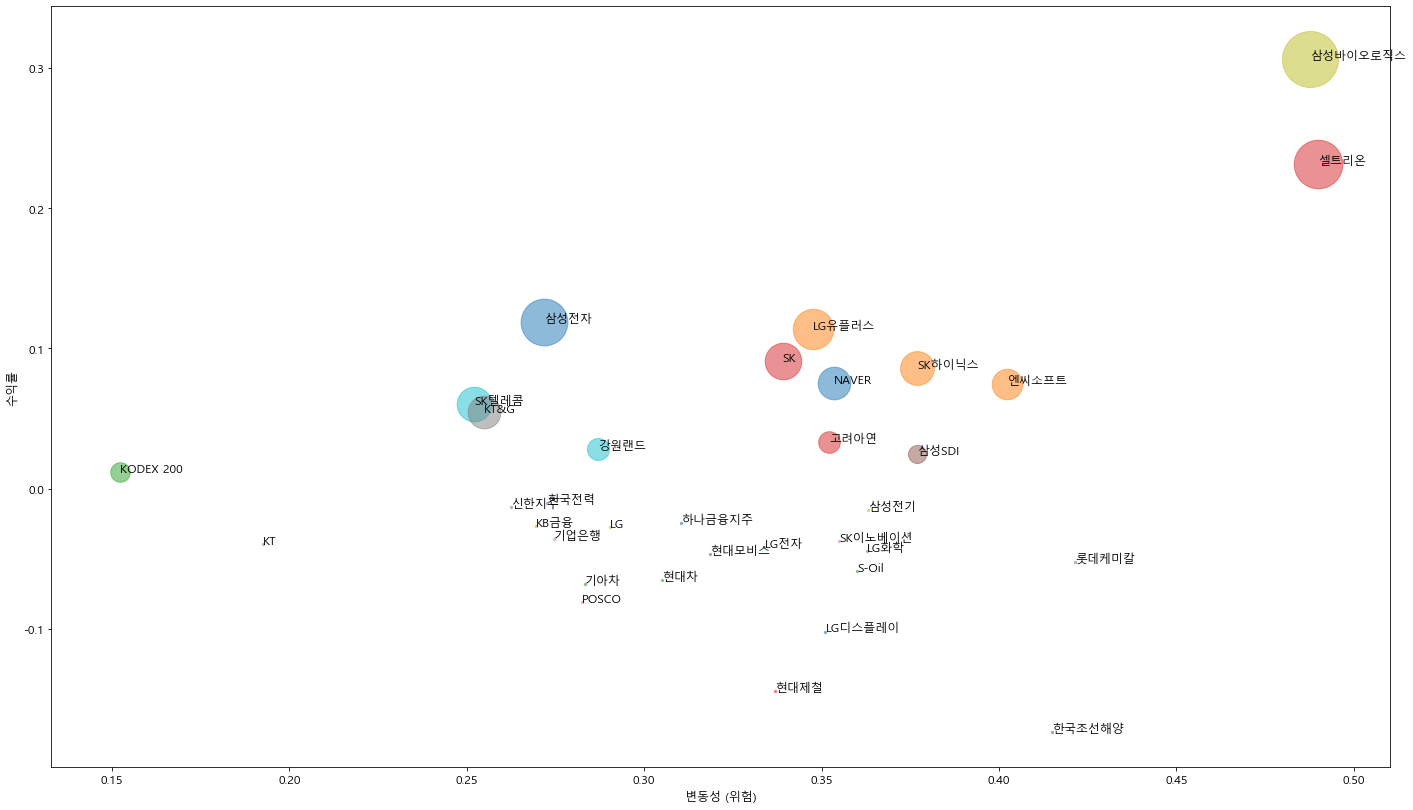

In [26]:
plotPortfolio(rv)

#고위험 고수익 애들 : 수익 높고 위험도 높음. 변동 폭 크면서도 계속 위로 올랐다는 말
#원이 큰 애들은 SR값이 큰애들

고위험 고수익 애들한테 분산투자율을 높이는건 그렇게 좋지 않다. 일단 과거의 자료이고, 변동폭이 크다는 것은 위험도가 매우 높다는 것.   고위험 고수익 // 저위험 저수익은 사람의 성향에 따라 다르기 때문에 둘이 같다고 봄.(무차별 곡선) 


* 포트폴리오 수익률 = 0.60 (%)
* 포트폴리오 변동성 = 11.73 (%)
* Sharp Ratio = 0.05


,name,rtn,vol,sr,weight
0,삼성전자,0.118884,0.271757,0.437463,0.029412
1,SK하이닉스,0.086255,0.376922,0.228840,0.029412
2,현대차,-0.065379,0.305028,-0.214339,0.029412
3,셀트리온,0.231236,0.490064,0.471848,0.029412
4,LG화학,-0.044298,0.362686,-0.122139,0.029412
5,현대모비스,-0.046859,0.318565,-0.147095,0.029412
6,POSCO,-0.080615,0.282381,-0.285481,0.029412
7,신한지주,-0.013113,0.262468,-0.049959,0.029412
8,삼성바이오로직스,0.306332,0.487630,0.628206,0.029412
9,SK텔레콤,0.060661,0.252186,0.240542,0.029412


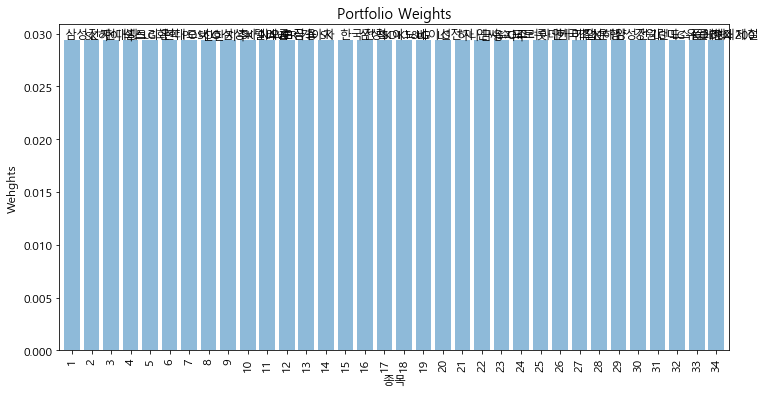

In [12]:
result = optPortfolio(rv, C, opt=False)
result[:10]

* 포트폴리오 수익률 = 0.60 (%)  
최근 10년 간의  주식 수익률이 별로 좋진 않았다는 얘기 


* 포트폴리오 수익률 = 30.63 (%)
* 포트폴리오 변동성 = 48.80 (%)
* Sharp Ratio = 0.63


,name,rtn,vol,sr,weight
0,삼성전자,0.118884,0.271757,0.437463,1.536817e-13
1,SK하이닉스,0.086255,0.376922,0.228840,9.229247e-14
2,현대차,-0.065379,0.305028,-0.214339,1.049840e-14
3,셀트리온,0.231236,0.490064,0.471848,0.000000e+00
4,LG화학,-0.044298,0.362686,-0.122139,2.880235e-14
5,현대모비스,-0.046859,0.318565,-0.147095,1.715624e-14
6,POSCO,-0.080615,0.282381,-0.285481,1.155993e-15
7,신한지주,-0.013113,0.262468,-0.049959,4.515635e-14
8,삼성바이오로직스,0.306332,0.487630,0.628206,1.000000e+00
9,SK텔레콤,0.060661,0.252186,0.240542,9.349322e-14


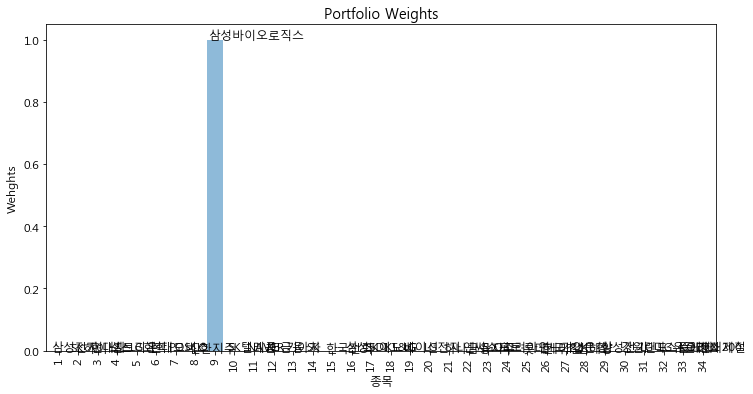

In [32]:
result = optPortfolio(rv, C, reg=-5, opt=True)  # opt = true로 주면 -sr이 min이 되게 최적화, reg=x--->=0으로 바꿔봐
result[:10]   #1n A 투자성과로 이득

아까보다 수익률, sr 높아짐!   
reg=0으로 돌렸을 때 일부 기업만 과도 성장한 모습을 보임-> 오버피팅, 과잉적합한 모습을 보여준다.  
50이 좋은가, 100이 좋은가를 판단하는 것은 분석가의 몫..



* 포트폴리오 수익률 = 1.91 (%)
* 포트폴리오 변동성 = 11.66 (%)
* Sharp Ratio = 0.16


,name,rtn,vol,sr,weight
0,삼성전자,0.118884,0.271757,0.437463,0.034239
1,SK하이닉스,0.086255,0.376922,0.228840,0.032678
2,현대차,-0.065379,0.305028,-0.214339,0.026426
3,셀트리온,0.231236,0.490064,0.471848,0.038698
4,LG화학,-0.044298,0.362686,-0.122139,0.026857
5,현대모비스,-0.046859,0.318565,-0.147095,0.027224
6,POSCO,-0.080615,0.282381,-0.285481,0.025523
7,신한지주,-0.013113,0.262468,-0.049959,0.028719
8,삼성바이오로직스,0.306332,0.487630,0.628206,0.041858
9,SK텔레콤,0.060661,0.252186,0.240542,0.032237


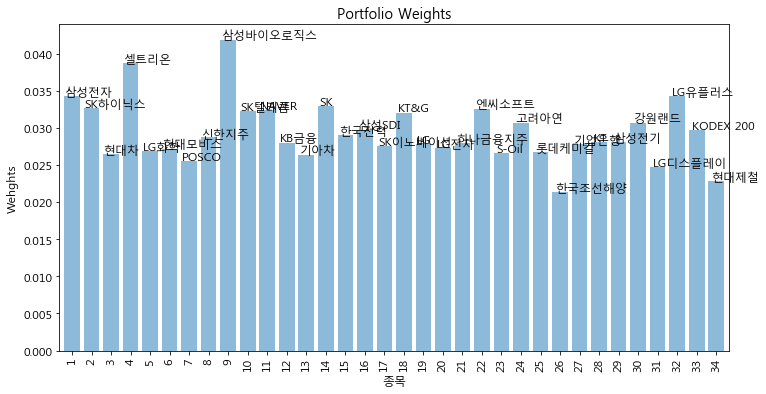

In [23]:
optPortfolio(rv,C, opt=True)